# Analyse ESG et rendements : clustering, tests et robustesse

Ce notebook analyse la relation entre scores ESG et rendements a partir de donnees corrigees et alignees.
Il combine visualisations, clustering et tests statistiques pour evaluer la structure des donnees.

Objectifs :
- Standardiser (Z-score) pour comparer ESG et rendements sur une base commune.
- Determiner le nombre de clusters via coude + silhouette (K-means).
- Visualiser et interpreter les clusters (PCA, profils).
- Tester DBSCAN pour capter le bruit et les outliers.
- Evaluer l'effet ESG par tests statistiques et regressions robustes.


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

sns.set_theme(style='whitegrid')


## 1) Charger les donnees ESG + rendements

On utilise `data/clean/panel_esg_returns.csv` genere par le notebook 04.


In [2]:
# Resolve project root via pyproject.toml
p = Path.cwd()
project_root = None
for _ in range(6):
    if (p / 'pyproject.toml').exists():
        project_root = p
        break
    if p.parent == p:
        break
    p = p.parent

if project_root is None:
    raise FileNotFoundError('pyproject.toml not found; cannot locate project root')

data_path = project_root / 'data/clean/panel_esg_returns.csv'
if not data_path.exists():
    raise FileNotFoundError('panel_esg_returns.csv not found. Run notebook 04 first.')

df = pd.read_csv(data_path)
df['Date'] = pd.to_datetime(df['Date'])
df.head()


,Date,Ticker,Env_Score,Soc_Score,ESG_Score,Entreprise,Yahoo_Ticker,Return
0,2015-12-31,000660 KS Equity,2.94,2.84,3.47,SK Hynix,000660.KS,NaN
1,2016-01-31,000660 KS Equity,2.94,2.84,3.47,SK Hynix,000660.KS,NaN
2,2016-02-29,000660 KS Equity,2.94,2.84,3.47,SK Hynix,000660.KS,0.098901
3,2016-03-31,000660 KS Equity,2.94,2.84,3.47,SK Hynix,000660.KS,-0.061667
4,2016-04-30,000660 KS Equity,2.94,2.84,3.47,SK Hynix,000660.KS,0.000000


### Lecture des donnees

Le tableau charge contient les scores ESG par entreprise et par date, ainsi que les rendements mensuels.
Il constitue la base de toute l'analyse : l'objectif est de voir si, a donnees comparables,
les rendements se structurent selon les niveaux ESG.


## 2) Controle qualite et couverture

On verifie la couverture temporelle et le taux de rendements manquants.


In [3]:
missing_return_pct = df['Return'].isna().mean() * 100
date_min, date_max = df['Date'].min(), df['Date'].max()
print('Missing Return %:', round(missing_return_pct, 2))
print('Date range:', date_min.date(), '->', date_max.date())

missing_by_ticker = (
    df.groupby('Yahoo_Ticker')['Return']
    .apply(lambda s: s.isna().mean())
    .sort_values(ascending=False)
)
missing_by_ticker.head(10)


Missing Return %: 7.59
Date range: 2015-12-31 -> 2026-01-31


Yahoo_Ticker
CRDO         0.606557
SNOW         0.475410
ENR.DE       0.475410
000660.KS    0.016393
6857.T       0.016393
9984.T       0.016393
META         0.008197
TSLA         0.008197
TSEM         0.008197
NVDA         0.008197
Name: Return, dtype: float64

### Analyse des rendements manquants

Le taux global de rendements manquants et la liste des tickers les plus incomplets indiquent
la solidite du panel. Des trous concentres sur quelques entreprises peuvent biaiser les
moyennes et les clusters. Si ce taux est eleve sur certains tickers, une coupe temporelle
ou une exclusion peut etre justifiee pour stabiliser les resultats.


## 3) Pourquoi la standardisation (Z-score) ?

Les rendements ont une volatilite beaucoup plus forte que les scores ESG.
Sans standardisation, les distances seraient presque entierement pilotees par les rendements.
On applique donc un Z-score sur toutes les features.


In [4]:
features = ['Env_Score', 'Soc_Score', 'ESG_Score', 'Return']
panel = df.dropna(subset=features).copy()

# Comparaison des echelles avant standardisation
desc = panel[features].describe().T[['mean','std','min','max']]
desc


,mean,std,min,max
Env_Score,3.951494,2.156510,0.000000,7.61
Soc_Score,3.056520,1.718407,0.540000,7.91
ESG_Score,4.146492,1.419527,1.360000,7.07
Return,0.034391,0.129177,-0.446203,0.78


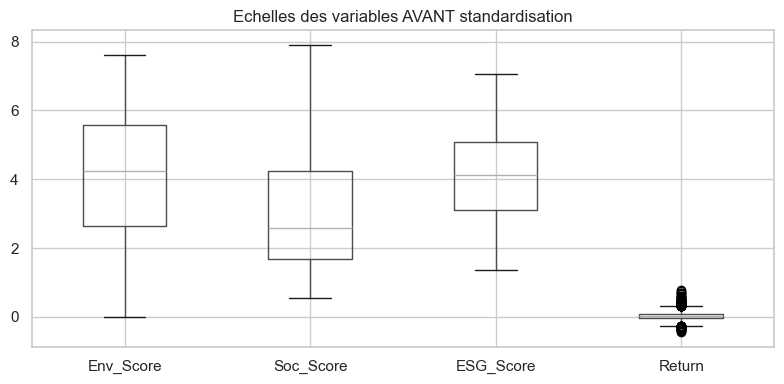

In [5]:
plt.figure(figsize=(8,4))
panel[features].boxplot()
plt.title('Echelles des variables AVANT standardisation')
plt.tight_layout()
plt.show()


### Lecture des echelles

Le boxplot met en evidence la difference d'echelle entre scores ESG et rendements.
Sans standardisation, les distances en clustering seraient presque entierement pilotees
par la volatilite des rendements.


In [6]:
scaler = StandardScaler()
X = scaler.fit_transform(panel[features])

# Verification des echelles apres standardisation
X_df = pd.DataFrame(X, columns=features)
X_df.describe().T[['mean','std']]


,mean,std
Env_Score,2.175431e-16,1.000207
Soc_Score,-1.175909e-16,1.000207
ESG_Score,5.879543e-18,1.000207
Return,5.879543e-17,1.000207


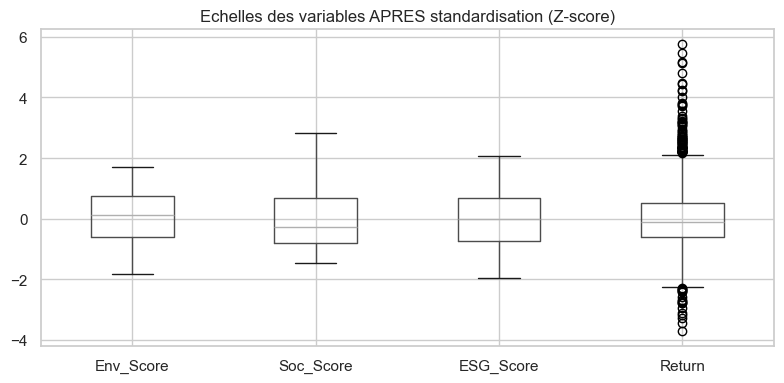

In [7]:
plt.figure(figsize=(8,4))
X_df.boxplot()
plt.title('Echelles des variables APRES standardisation (Z-score)')
plt.tight_layout()
plt.show()


### Effet de la standardisation (Z-score)

Apres standardisation, chaque variable contribue de maniere comparable aux distances.
C'est une condition necessaire pour tester proprement la relation ESG-rendements.


## 3bis) Visualisations ESG vs rendements

Objectif : voir si les rendements semblent se structurer selon les niveaux ESG.

On ajoute :
- Correlation ESG/rendement
- Scatter avec tendance
- Rendement moyen par quartile ESG
- Serie temporelle moyenne ESG vs rendement


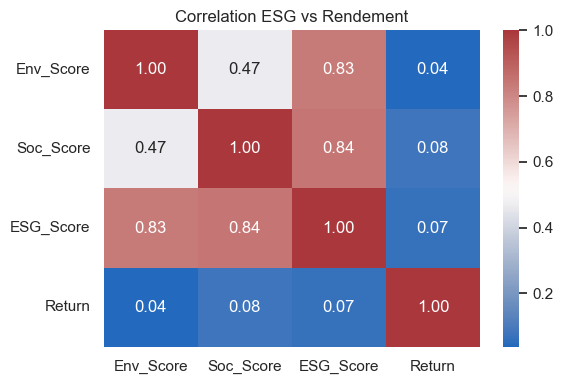

In [8]:
# Correlation simple entre ESG et rendement
corr = panel[['Env_Score','Soc_Score','ESG_Score','Return']].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='vlag', fmt='.2f')
plt.title('Correlation ESG vs Rendement')
plt.tight_layout()
plt.show()


### Interpretation de la correlation

La matrice montre l'association lineaire moyenne entre ESG et rendements.
Une correlation faible (proche de 0) suggere un lien direct limite.
Analyse critique : la correlation ne capte ni les non-linearites, ni les effets sectoriels,
ni les regimes de marche. Elle reste un indicateur descriptif.


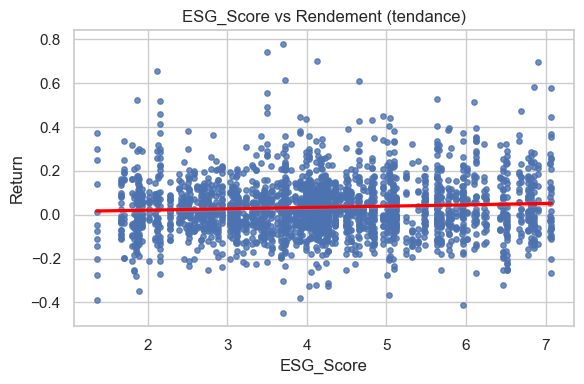

In [9]:
# Scatter ESG_Score vs Return avec tendance
plt.figure(figsize=(6,4))
sns.regplot(data=panel, x='ESG_Score', y='Return', scatter_kws={'s':15}, line_kws={'color':'red'})
plt.title('ESG_Score vs Rendement (tendance)')
plt.tight_layout()
plt.show()


### Lecture du scatter + tendance

La pente de la droite donne une intuition de l'effet moyen ESG -> rendement.
Si la pente est faible ou la dispersion tres large, l'effet est fragile.
Analyse critique : une relation globale peut masquer des sous-groupes ou des effets temporels.


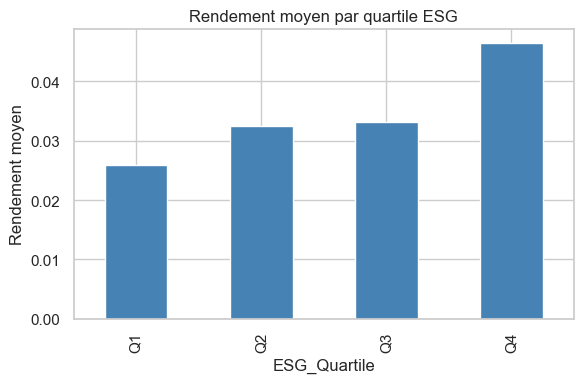

In [10]:
# Rendement moyen par quartile ESG
panel['ESG_Quartile'] = pd.qcut(panel['ESG_Score'], 4, labels=['Q1','Q2','Q3','Q4'])
quartile_mean = panel.groupby('ESG_Quartile')['Return'].mean().reindex(['Q1','Q2','Q3','Q4'])
plt.figure(figsize=(6,4))
quartile_mean.plot(kind='bar', color='steelblue')
plt.title('Rendement moyen par quartile ESG')
plt.ylabel('Rendement moyen')
plt.tight_layout()
plt.show()


### Quartiles ESG

On compare les rendements moyens par niveau ESG. Si Q4 > Q1 de maniere nette,
cela suggere un gradient favorable a l'ESG.
Analyse critique : sans tests statistiques et sans controle de facteurs (taille, secteur),
on ne peut pas conclure a un effet causal.


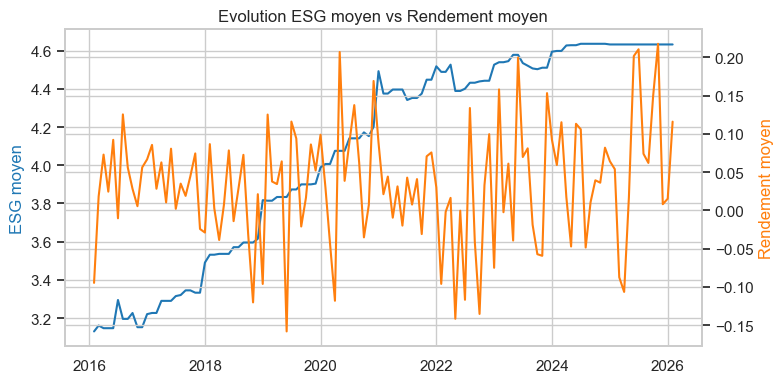

In [11]:
# Serie temporelle moyenne ESG vs rendement
ts = panel.groupby('Date')[['ESG_Score','Return']].mean().reset_index()
fig, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(ts['Date'], ts['ESG_Score'], color='tab:blue', label='ESG moyen')
ax1.set_ylabel('ESG moyen', color='tab:blue')
ax2 = ax1.twinx()
ax2.plot(ts['Date'], ts['Return'], color='tab:orange', label='Rendement moyen')
ax2.set_ylabel('Rendement moyen', color='tab:orange')
plt.title('Evolution ESG moyen vs Rendement moyen')
plt.tight_layout()
plt.show()


### Serie temporelle ESG vs rendement

Cette vue donne une intuition macro : les tendances ESG globales suivent-elles
les rendements moyens ?
Analyse critique : l'alignement visuel ne prouve pas de lien causal et peut etre influence par
des cycles de marche.


## 4) K-means : methode du coude et silhouette

On combine deux criteres :
- Inertie (methode du coude)
- Silhouette (cohesion/separation)


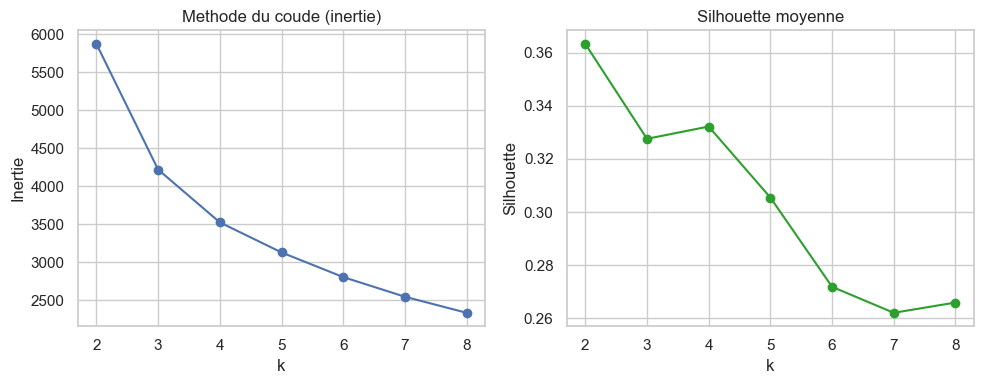

In [12]:
inertias = []
sil_scores = []
ks = range(2, 9)

for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X, labels))

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(list(ks), inertias, marker='o')
ax[0].set_title('Methode du coude (inertie)')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Inertie')

ax[1].plot(list(ks), sil_scores, marker='o', color='tab:green')
ax[1].set_title('Silhouette moyenne')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Silhouette')

plt.tight_layout()
plt.show()


### Choix de k (coude + silhouette)

Le coude indique un point de rendements decroissants de l'inertie.
La silhouette mesure la separation moyenne entre clusters.
Un k optimal doit etre interpretable et stable ; un maximum a k faible
peut indiquer une structure globale plutot que des sous-groupes fins.


In [13]:
best_k = ks[int(np.argmax(sil_scores))]
best_k


2

### Interpretation du k retenu

Le k selectionne est celui qui maximise la silhouette.
Analyse critique : un k=2 peut etre trop grossier pour un papier si l'objectif est une
segmentation fine. Il faut alors justifier ce choix ou explorer des k alternatifs.


## 5) K-means final et visualisation (PCA)


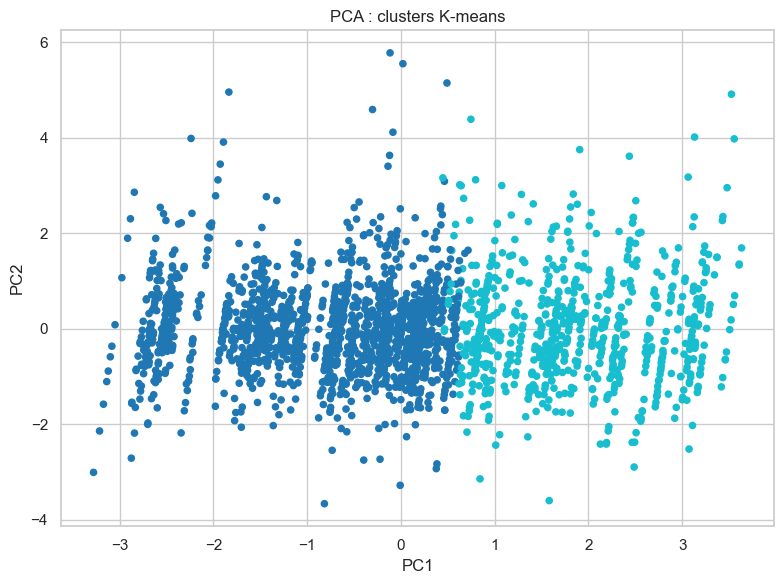

In [14]:
km = KMeans(n_clusters=best_k, n_init=10, random_state=42)
panel['Cluster_KMeans'] = km.fit_predict(X)

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(Z[:,0], Z[:,1], c=panel['Cluster_KMeans'], cmap='tab10', s=20)
plt.title('PCA : clusters K-means')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()


p### Lecture de la PCA coloree par K-means

Si les clusters se chevauchent fortement, la separation est faible.
Analyse critique : la PCA est une projection 2D et peut masquer des separations en dimensions superieures.


In [15]:
# Profilage des clusters (moyennes standardisees)
cluster_profile = panel.groupby('Cluster_KMeans')[features].mean()
cluster_profile


,Env_Score,Soc_Score,ESG_Score,Return
Cluster_KMeans,,,,
0,3.142904,2.145042,3.380169,0.027582
1,5.724624,5.055271,5.826935,0.049324


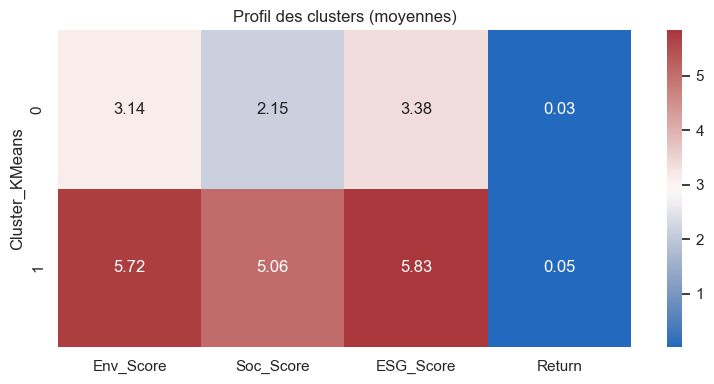

In [16]:
plt.figure(figsize=(8,4))
sns.heatmap(cluster_profile, annot=True, fmt='.2f', cmap='vlag')
plt.title('Profil des clusters (moyennes)')
plt.tight_layout()
plt.show()


### Profil des clusters

Les moyennes par cluster permettent d'interpreter la nature des groupes (ESG faible/fort,
rendement moyen plus ou moins eleve).
Analyse critique : les differences peuvent etre dues a des facteurs confondants non controles.


## 6) DBSCAN : gestion du bruit et des outliers

On estime `eps` via un k-distance plot (k=5).


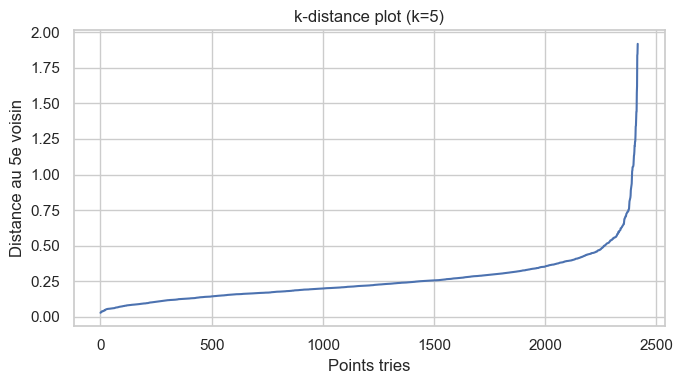

0.4275872767873996

In [17]:
k = 5
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X)
distances, _ = nn.kneighbors(X)
k_dist = np.sort(distances[:, -1])

plt.figure(figsize=(7,4))
plt.plot(k_dist)
plt.title('k-distance plot (k=5)')
plt.xlabel('Points tries')
plt.ylabel('Distance au 5e voisin')
plt.tight_layout()
plt.show()

eps = float(np.percentile(k_dist, 90))
eps


### Interpretation du k-distance plot (DBSCAN)

La courbe ne presente pas de coude net, ce qui indique une structure diffuse :
- les densites varient de maniere progressive,
- il n'existe pas de seuil de densite evident pour separer des groupes stables.

Analyse critique : le choix d'`eps` est donc heuristique.
De faibles variations de `eps` peuvent changer fortement le nombre de clusters et la part
de points consideres comme bruit.


### Choix d'eps pour DBSCAN

Le coude du k-distance plot suggere un eps raisonnable.
Analyse critique : ce choix est heuristique ; de petits changements peuvent modifier fortement
le nombre de clusters et le volume de bruit.


In [18]:
db = DBSCAN(eps=eps, min_samples=k)
panel['Cluster_DBSCAN'] = db.fit_predict(X)

panel['Cluster_DBSCAN'].value_counts()


Cluster_DBSCAN
 0     1348
 1      260
 3      228
-1      136
 9      110
 2      102
 4       66
 13      43
 10      39
 6       22
 11      11
 7       10
 16      10
 8        9
 15       8
 5        5
 12       5
 14       5
Name: count, dtype: int64

### Interpretation DBSCAN

Un volume important de points en bruit (-1) suggere une structure diffuse et heterogene.
Analyse critique : DBSCAN confirme souvent l'absence de densites claires si les variables
ne structurent pas fortement l'espace.


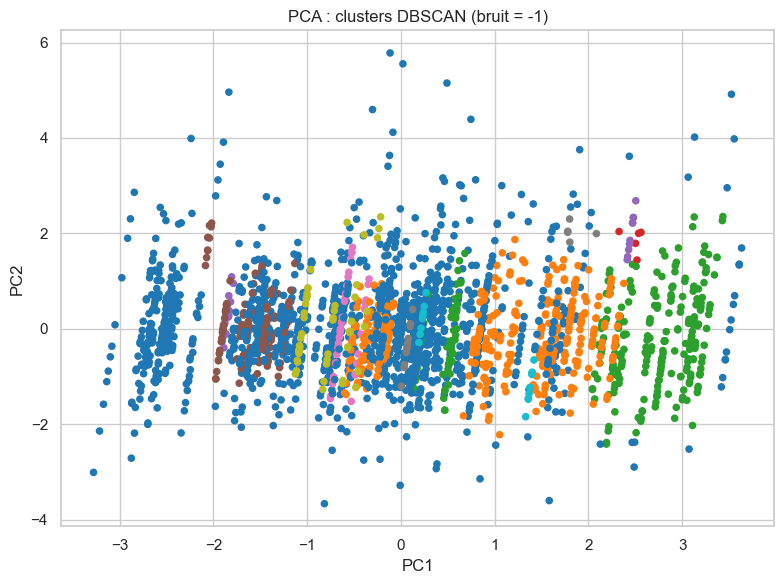

In [19]:
plt.figure(figsize=(8,6))
plt.scatter(Z[:,0], Z[:,1], c=panel['Cluster_DBSCAN'], cmap='tab10', s=20)
plt.title('PCA : clusters DBSCAN (bruit = -1)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()


## 7) Variations annuelles (optionnel)

On calcule les variations annuelles ESG et rendements, puis clustering standardise.


In [20]:
annual = df.copy()
annual['Year'] = annual['Date'].dt.year

annual_last = (
    annual.sort_values('Date')
    .groupby(['Yahoo_Ticker','Year'])
    .tail(1)
)

annual_last['Env_Var'] = annual_last.groupby('Yahoo_Ticker')['Env_Score'].pct_change()
annual_last['Soc_Var'] = annual_last.groupby('Yahoo_Ticker')['Soc_Score'].pct_change()
annual_last['ESG_Var'] = annual_last.groupby('Yahoo_Ticker')['ESG_Score'].pct_change()
annual_last['Return_Var'] = annual_last.groupby('Yahoo_Ticker')['Return'].pct_change()

annual_last = annual_last.replace([np.inf, -np.inf], np.nan)

var_features = ['Env_Var','Soc_Var','ESG_Var','Return_Var']
annual_clust = annual_last.dropna(subset=var_features).copy()

scaler_var = StandardScaler()
X_var = scaler_var.fit_transform(annual_clust[var_features])

km_var = KMeans(n_clusters=3, n_init=10, random_state=42)
annual_clust['Cluster_KMeans_Var'] = km_var.fit_predict(X_var)

annual_clust[['Yahoo_Ticker','Year','Cluster_KMeans_Var']].head()


,Yahoo_Ticker,Year,Cluster_KMeans_Var
1610,LRCX,2017,0
2220,NVDA,2017,0
390,9984.T,2017,0
1976,MSFT,2017,0
2586,TSLA,2017,1


## 8) Tests statistiques sur les quartiles ESG

On teste si les rendements moyens sont significativement differents selon le niveau ESG :
- ANOVA (toutes les moyennes)
- t-tests par paire avec correction de Bonferroni


In [21]:
from scipy import stats

quartiles = panel.groupby('ESG_Quartile')['Return'].apply(list)
anova_res = stats.f_oneway(*quartiles)
anova_res


F_onewayResult(statistic=np.float64(2.693712097465422), pvalue=np.float64(0.04460087556908589))

### Resultat ANOVA

Si la p-value est elevee, les differences de moyennes entre quartiles ESG ne sont pas
statistiquement convaincantes. Si elle est faible, il existe au moins une difference.
Analyse critique : l'ANOVA ne dit pas quelles paires sont differentes.


In [22]:
# t-tests par paire + Bonferroni
pairs = [('Q1','Q2'),('Q1','Q3'),('Q1','Q4'),('Q2','Q3'),('Q2','Q4'),('Q3','Q4')]
results = []
m = len(pairs)
for a,b in pairs:
    tstat, pval = stats.ttest_ind(
        panel.loc[panel['ESG_Quartile']==a,'Return'],
        panel.loc[panel['ESG_Quartile']==b,'Return'],
        equal_var=False, nan_policy='omit'
    )
    results.append((a,b,tstat,pval, min(pval*m,1.0)))

tests_df = pd.DataFrame(results, columns=['Q_A','Q_B','t','p','p_bonf'])
tests_df


,Q_A,Q_B,t,p,p_bonf
0,Q1,Q2,-0.917117,0.359267,1.000000
1,Q1,Q3,-1.061395,0.288720,1.000000
2,Q1,Q4,-2.712723,0.006773,0.040638
3,Q2,Q3,-0.095687,0.923785,1.000000
4,Q2,Q4,-1.750007,0.080378,0.482266
5,Q3,Q4,-1.723296,0.085102,0.510614


### Resultat des t-tests

On identifie quelles paires de quartiles diffèrent.
La correction de Bonferroni est conservative : un resultat significatif est plus robuste.
Analyse critique : les tests restent descriptifs sans controle de variables confondantes.


### Commentaire critique (quartiles)

- Si l'ANOVA est non significative, l'effet des quartiles ESG sur le rendement est faible.
- Si seules certaines paires sont significatives, l'effet est local (pas generalise).
- Ces tests restent descriptifs : ils ne controlent pas les facteurs sectoriels ou macro.


## 9) Regressions simples (effet ESG sur rendement)

On estime l'effet moyen ESG -> rendement :
- Modele 1: Return ~ ESG
- Modele 2: Return ~ ESG + Env + Soc (attention: colinearite avec ESG)
- Modele 3: Return ~ ESG + effets temporels (annee)


In [23]:
import statsmodels.api as sm

# Assurer les types numeriques
panel['Return'] = pd.to_numeric(panel['Return'], errors='coerce')
panel['ESG_Score'] = pd.to_numeric(panel['ESG_Score'], errors='coerce')
panel['Env_Score'] = pd.to_numeric(panel['Env_Score'], errors='coerce')
panel['Soc_Score'] = pd.to_numeric(panel['Soc_Score'], errors='coerce')

# Modele 1
X1 = sm.add_constant(panel['ESG_Score'])
m1 = sm.OLS(panel['Return'], X1, missing='drop').fit(cov_type='HC3')

# Modele 2 (multicolinearite possible)
X2 = sm.add_constant(panel[['ESG_Score','Env_Score','Soc_Score']])
m2 = sm.OLS(panel['Return'], X2, missing='drop').fit(cov_type='HC3')

# Modele 3: effets temporels (annee)
panel['Year'] = panel['Date'].dt.year
year_dummies = pd.get_dummies(panel['Year'], prefix='Year', drop_first=True).astype(float)
X3 = pd.concat([panel[['ESG_Score']], year_dummies], axis=1)
X3 = sm.add_constant(X3)
m3 = sm.OLS(panel['Return'], X3, missing='drop').fit(cov_type='HC3')

summary_table = pd.DataFrame({
    'coef_ESG': [m1.params.get('ESG_Score'), m2.params.get('ESG_Score'), m3.params.get('ESG_Score')],
    'p_ESG': [m1.pvalues.get('ESG_Score'), m2.pvalues.get('ESG_Score'), m3.pvalues.get('ESG_Score')],
    'R2': [m1.rsquared, m2.rsquared, m3.rsquared],
}, index=['Model1','Model2','Model3'])
summary_table


,coef_ESG,p_ESG,R2
Model1,0.006054,0.002726,0.004426
Model2,-0.003644,0.677471,0.006642
Model3,0.005498,0.013787,0.053335


### Lecture des regressions

Le coefficient ESG mesure l'effet moyen estime sur le rendement.
Un coefficient instable ou non significatif entre modeles indique une absence de robustesse.
Le R2 montre la part de variance expliquee : faible R2 = effet ESG limite.
Analyse critique : la colinearite (ESG vs Env/Soc) peut rendre les coefficients instables.


### Commentaire critique (regressions)

- Si le coefficient ESG est instable ou non significatif selon les modeles, l'effet n'est pas robuste.
- Le R2 devrait rester faible: l'ESG seul explique une faible part de la variance des rendements.
- Le modele 2 peut souffrir de colinearite (ESG est deja une combinaison de Env/Soc).


## 10) Robustesse par periode (pre/post 2020)

On verifie si l'effet ESG sur rendement change selon la periode.


In [24]:
panel['Period'] = np.where(panel['Date'] < '2020-01-01', 'pre2020', 'post2020')
res = []
for period, sub in panel.groupby('Period'):
    Xp = sm.add_constant(sub['ESG_Score'])
    mp = sm.OLS(sub['Return'], Xp).fit(cov_type='HC3')
    res.append((period, mp.params.get('ESG_Score'), mp.pvalues.get('ESG_Score'), mp.rsquared))

period_df = pd.DataFrame(res, columns=['Period','coef_ESG','p_ESG','R2'])
period_df


,Period,coef_ESG,p_ESG,R2
0,post2020,0.004925,0.085578,0.002297
1,pre2020,0.007565,0.026321,0.008748


### Robustesse temporelle

Comparer pre/post 2020 verifie si l'effet ESG est stable.
Si l'effet n'existe que sur une periode, il est probablement conjoncturel.


### Commentaire critique (robustesse)

- Si l'effet ESG n'existe que sur une periode, il est probablement conjoncturel.
- Un effet stable pre/post 2020 serait plus credibile.


## 8) Sauvegarder les resultats


In [25]:
out_dir = project_root / 'data/clean'
out_dir.mkdir(parents=True, exist_ok=True)

panel.to_csv(out_dir / 'clustering_esg_returns_kmeans_dbscan.csv', index=False)
pd.DataFrame({'k': list(ks), 'inertia': inertias, 'silhouette': sil_scores}).to_csv(
    out_dir / 'silhouette_esg_returns_kmeans.csv', index=False
)
annual_clust.to_csv(out_dir / 'clustering_esg_returns_variations.csv', index=False)


## Conclusion generale

### Synthese
- Les analyses descriptives (correlation, quartiles) suggerent au mieux une association faible
  entre ESG et rendements, avec une grande dispersion.
- Le clustering K-means propose une separation grossiere (k faible) et DBSCAN revele une structure
  diffuse, indiquant une relation ESG-rendement peu structuree.
- Les regressions confirment que l'effet ESG est instable et explique une part limitee des rendements.

### Limites
- Panel restreint (23 entreprises) et trous de donnees pour certains tickers.
- Absence de controles sectoriels et de facteurs financiers (taille, beta, momentum).
- Resultats sensibles aux periodes de marche et aux choix de pre-traitement.

### Implications
- Les donnees disponibles ne permettent pas de conclure a un effet causal fort de l'ESG
  sur les rendements. Elles indiquent au mieux un effet faible et non robuste.
- Pour une validation robuste, il faut enrichir le panel (plus d'entreprises, controle sectoriel)
  et tester des modeles avec variables de controle.
